In [1]:
%load_ext autoreload
%autoreload 2

import os
import os.path as osp
import math

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from datasets.hitgraphs import HitGraphDatasetG
import torch_geometric.transforms as T
from torch_geometric.data import DataLoader
from torch_geometric.utils import normalized_cut
from torch_geometric.nn import (NNConv, graclus, max_pool, max_pool_x,
                                global_mean_pool)
import tqdm
import argparse

from models.gnn_geometric import GNNSegmentClassifierG as Net
from EdgeNet import EdgeNet

from heptrx_nnconv import test

from datasets.graph import draw_sample

import awkward
import matplotlib.pyplot as plt
import scipy.stats as stats

model_fname = "EdgeNet_13579_5946285673_sitonga.best.pth"

batch_size = 1
hidden_dim = 64
n_iters = 6

device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')
print('using device %s'%device)



using device cuda:2
using device cuda:2


In [2]:
directed = False
path = osp.join(osp.dirname(os.path.abspath('.')), 'training_data', 'single_photon')
full_dataset = HitGraphDatasetG(path, directed=directed)
fulllen = len(full_dataset)
tv_frac = 0.10
tv_num = math.ceil(fulllen*tv_frac)
splits = np.cumsum([fulllen-2*tv_num,tv_num,tv_num])

test_dataset = torch.utils.data.Subset(full_dataset,np.arange(start=splits[0],stop=splits[1]))
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

test_samples = len(test_dataset)

d = full_dataset
num_features = d.num_features
num_classes = d[0].y.max().item() + 1 if d[0].y.dim() == 1 else d[0].y.size(1)

model = EdgeNet(input_dim=num_features,hidden_dim=hidden_dim,n_iters=n_iters).to(device)
print('Model: \n%s\nParameters: %i' %
      (model, sum(p.numel()
                  for p in model.parameters())))
print('Testing with %s samples'%test_samples)

model.load_state_dict(torch.load(model_fname))

test_loss, test_acc, test_eff, test_fp, test_fn, test_pur = test(model, test_loader, test_samples)
print('Testing: Loss: {:.4f}, Eff.: {:.4f}, FalsePos: {:.4f}, FalseNeg: {:.4f}, Purity: {:,.4f}'.format(test_loss, test_eff,
                                                                                                        test_fp, test_fn, test_pur))

figs = []
out = []
y = []
x = []
edge_index = []
#simmatched = []
for i,data in enumerate(test_loader):
    x.append(data.x.cpu().detach().numpy())
    y.append(data.y.cpu().detach().numpy())
    edge_index.append(data.edge_index.cpu().detach().numpy())
    #simmatched.append(data.sim_matched.cpu().detach().numpy())
    data = data.to(device)
    out.append(model(data).cpu().detach().numpy())

  0%|          | 0/25.0 [00:00<?, ?it/s]

Model: 
EdgeNet(
  (inputnet): Sequential(
    (0): Linear(in_features=5, out_features=64, bias=True)
    (1): Tanh()
  )
  (edgenetwork): Sequential(
    (0): Linear(in_features=138, out_features=1, bias=True)
    (1): Sigmoid()
  )
  (nodenetwork): EdgeConv(nn=Sequential(
    (0): Linear(in_features=138, out_features=64, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): Sigmoid()
  ))
)
Parameters: 13579
Testing with 200 samples


batch loss = 0.00839: : 200it [00:02, 69.43it/s]                       


scor 9025974 stru 1887856.0 stp 1879115 stn 7146859 sfp 148751 sfn 8741 stot 9183466
Testing: Loss: 0.0488, Eff.: 0.9954, FalsePos: 0.0204, FalseNeg: 0.0046, Purity: 0.9266


In [3]:
print("Processing awkward arrays...")    
out = awkward.fromiter(out)
x = awkward.fromiter(x)
y = awkward.fromiter(y)
#simmatched = awkward.fromiter(simmatched) 
edge_index = awkward.fromiter(edge_index)

Processing awkward arrays...


In [4]:
predicted_edge = (out > 0.5)
truth_edge = (y > 0.5)
node_energy = x[:,:,4]
node_layer = x[:,:,2]

predicted_connected_node_indices = awkward.JaggedArray.concatenate([edge_index[:,0][predicted_edge], edge_index[:,1][predicted_edge]], axis=1)
predicted_connected_node_indices = awkward.fromiter(map(np.unique, predicted_connected_node_indices))
predicted_energy_sum = node_energy[predicted_connected_node_indices].sum()
truth_connected_node_indices = awkward.JaggedArray.concatenate([edge_index[:,0][truth_edge],edge_index[:,1][truth_edge]], axis=1)
truth_connected_node_indices = awkward.fromiter(map(np.unique, truth_connected_node_indices))
truth_energy_sum = node_energy[truth_connected_node_indices].sum()

Plotting...


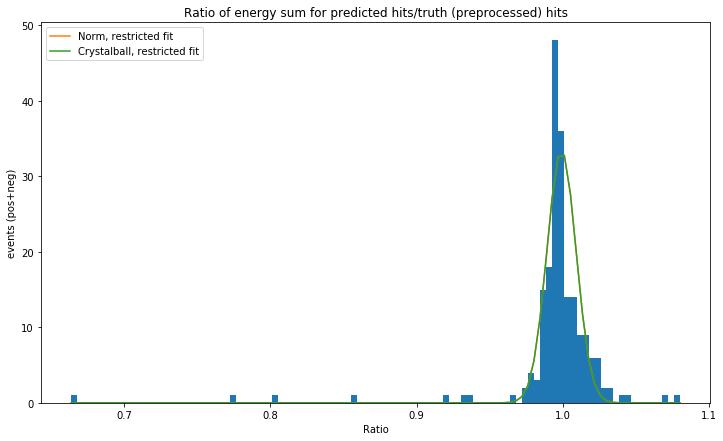

In [5]:
print ("Plotting...")
nonzeromask = (truth_energy_sum !=0.0)
energy_captured_ratio = predicted_energy_sum[nonzeromask]/truth_energy_sum[nonzeromask]

fig,axes = plt.subplots(figsize=(12, 7))
_, bins,_ = axes.hist(energy_captured_ratio, bins=100)
axes.set_title("Ratio of energy sum for predicted hits/truth (preprocessed) hits")
axes.set_ylabel("events (pos+neg)")
axes.set_xlabel("Ratio")
cut = energy_captured_ratio[(energy_captured_ratio>0.975) & (energy_captured_ratio < 1.025)] #NB: restricted fit
(mu, sigma) = stats.norm.fit(cut)
c_paras = stats.crystalball.fit(cut)
lnspc = np.linspace(bins[0], bins[-1], len(bins))
pdf_g = stats.norm.pdf(lnspc, mu, sigma)
pdf_c = stats.crystalball.pdf(lnspc, *c_paras)
pdf_g = pdf_g / pdf_g.sum() * len(energy_captured_ratio)
pdf_c = pdf_c / pdf_c.sum() * len(energy_captured_ratio)
axes.plot(lnspc, pdf_g, label="Norm, restricted fit")
axes.plot(lnspc, pdf_c, label="Crystalball, restricted fit")
axes.legend(loc='upper left')
figs.append(fig)

100%|██████████| 44646/44646 [00:57<00:00, 773.08it/s] 


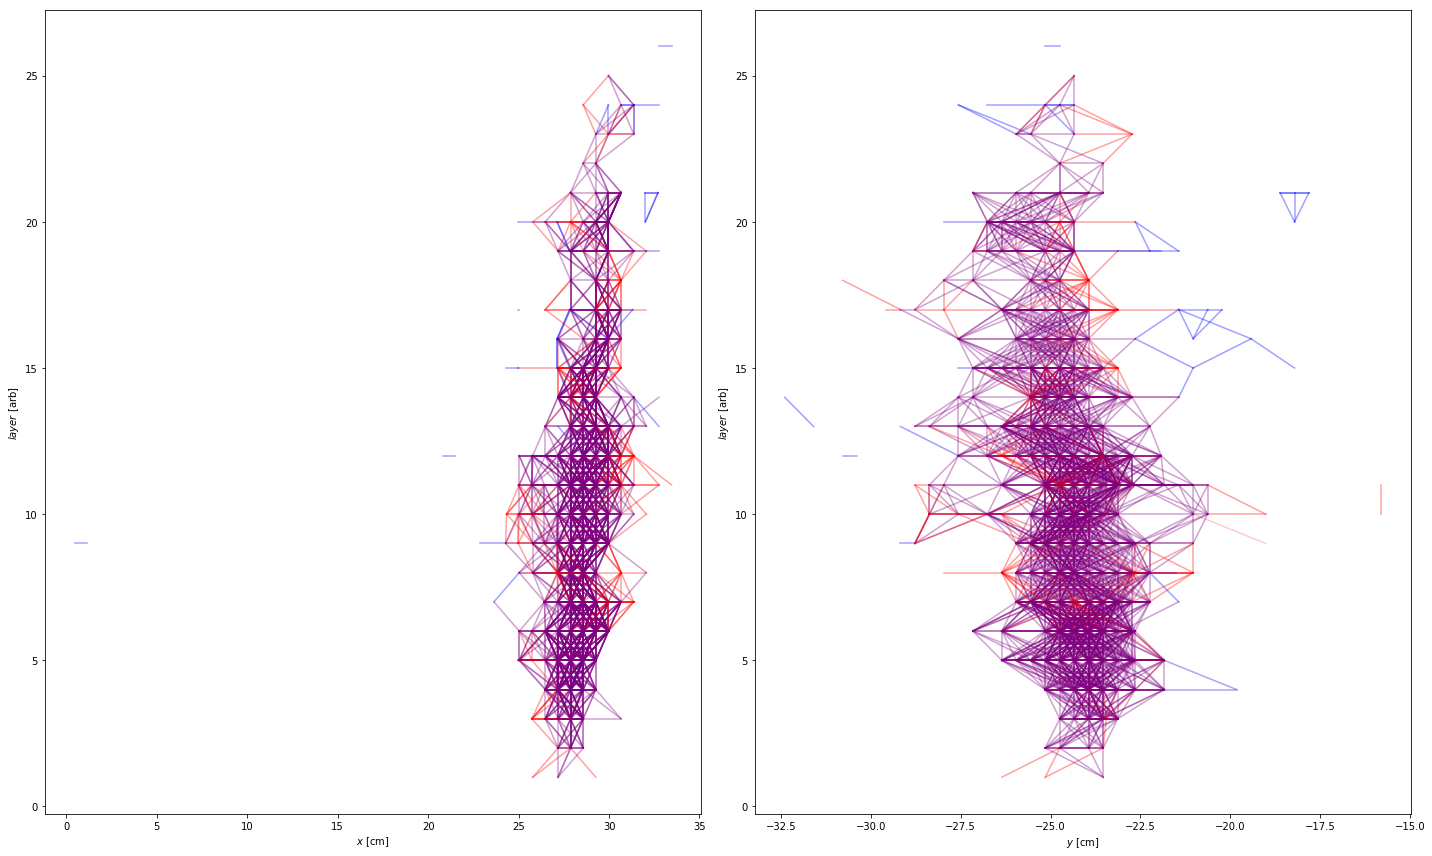

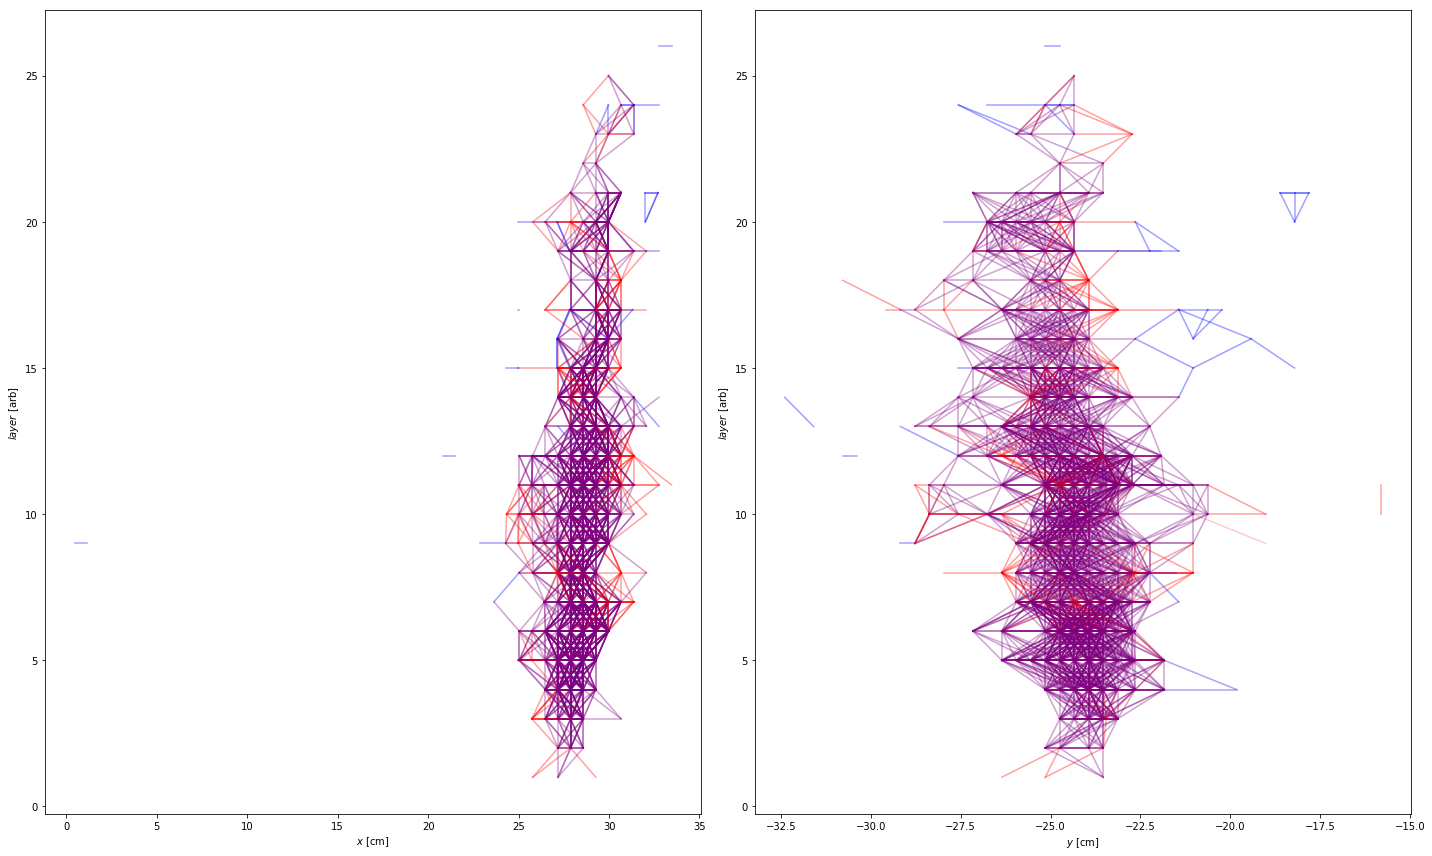

In [6]:
idx = 0
draw_sample(x[idx].regular(), edge_index[idx].regular()[0], edge_index[idx].regular()[1], y[idx], out[idx])